In [1]:
import sys
sys.path.append('../')  # Ajustez le chemin selon la structure de votre dossier


In [2]:
import torch
from src.models.object_detector import FasterRCNNModule


In [3]:

# Assuming the model configuration is consistent
model_checkpoint_path = '/home/olivier/projet/pi/monorepo/doc-analyzer/model-experiment/notebooks/mlruns/631769544733170278/d8a9914b7a2c48d789ea8330c779dca5/checkpoints/epoch=1-step=128.ckpt'

model = FasterRCNNModule.load_from_checkpoint(model_checkpoint_path)


In [4]:

# Ensure the model is in evaluation mode
model.eval()


FasterRCNNModule(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05,

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

FasterRCNNModule(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05,

In [6]:
# Load an image
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import functional as F

image_path = '/home/olivier/projet/pi/monorepo/doc-analyzer/model-experiment/data/test/images/Grotius_Dg-038.png'

image = Image.open(image_path)
image = F.to_tensor(image).unsqueeze(0)
image = image.to(device)

In [7]:
from src.utils.dataloader import create_dataloader
data_dir = '../data'
data_loader = create_dataloader(data_dir, 'test', batch_size=4, num_workers=4, shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


**IntersectionOverUnion**

In [8]:
img, target = next(iter(data_loader))

In [9]:
predictions = model(img)

In [10]:
from torchmetrics.detection import IntersectionOverUnion
# preds = [
#    {
#        "boxes": torch.tensor([
#             [296.55, 93.96, 314.97, 152.79],
#             [298.55, 98.96, 314.97, 151.79]]),
#        "labels": torch.tensor([4, 5]),
#    }
# ]
# target = [
#    {
#        "boxes": torch.tensor([[300.00, 100.00, 315.00, 150.00]]),
#        "labels": torch.tensor([5]),
#    }
# ]
metric = IntersectionOverUnion(class_metrics=True)
wow = metric(predictions, target)
wow

{'iou': tensor(0.0401, grad_fn=<SqueezeBackward0>),
 'iou/cl_0': tensor(nan, grad_fn=<SqueezeBackward0>),
 'iou/cl_1': tensor(0.0402, grad_fn=<SqueezeBackward0>),
 'iou/cl_2': tensor(0., grad_fn=<SqueezeBackward0>)}

In [11]:
metric.groundtruth_labels

[tensor([1, 0, 1, 1, 1, 1, 1, 1]),
 tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])]

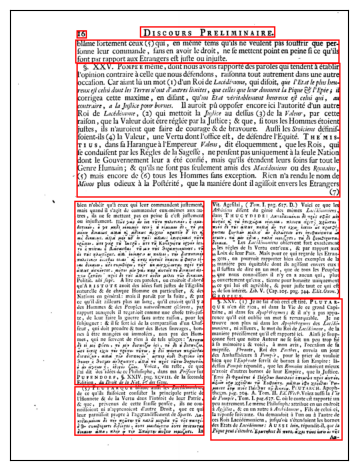

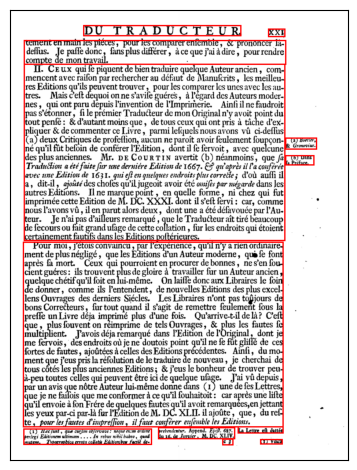

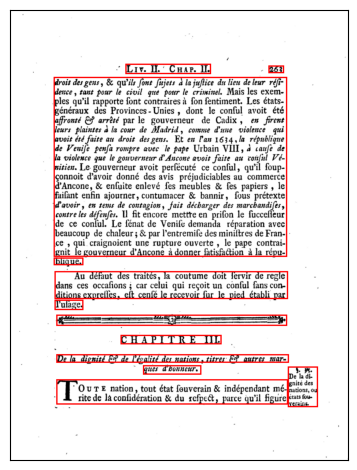

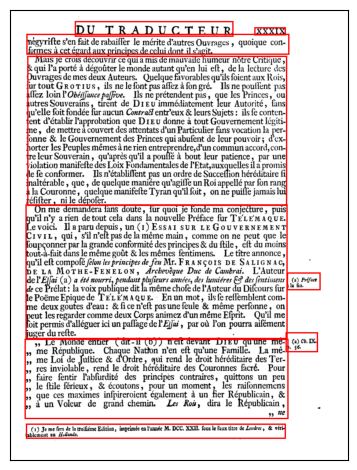

In [12]:
from src.utils.helper import plot

for i, t in zip(img, target):
    zup = (i,t)
    plot([zup])

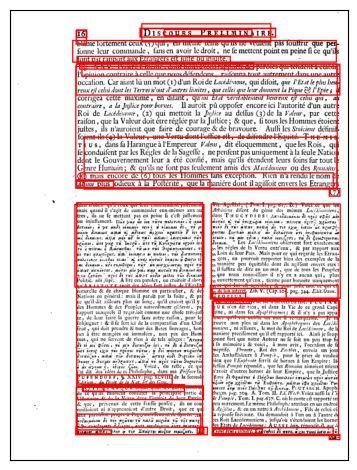

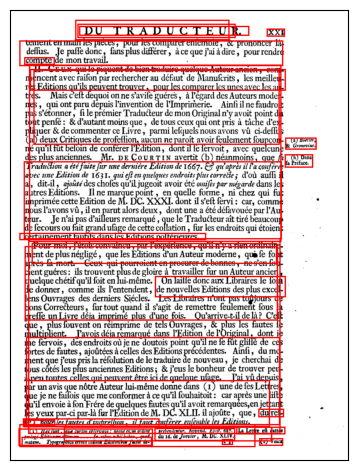

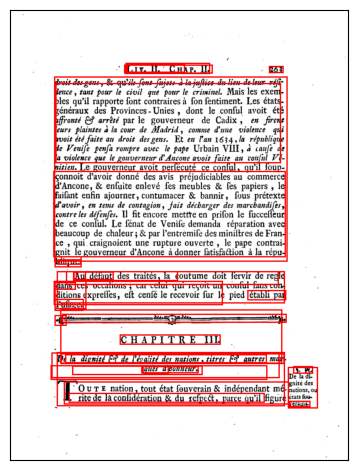

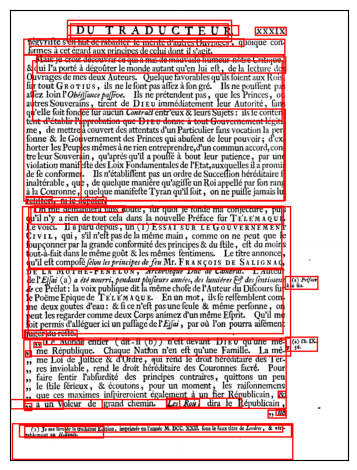

In [13]:
for i, t in zip(img, predictions):
    zup = (i,t)
    plot([zup])

**Confusion Matrix**

In [14]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
img, target = next(iter(data_loader))
predictions = model(img)


In [15]:
import pandas as pd

preds = pd.DataFrame(predictions)['labels'].to_list()
labels = pd.DataFrame(target)['labels'].to_list()

In [16]:
preds

[tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1]),
 tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
         1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1])]

In [20]:
target

[{'boxes': BoundingBoxes([[ 68.6887, 453.7236, 648.4213, 660.4661],
                 [ 17.9739, 867.3633, 692.4585, 959.2845],
                 [347.5648, 954.6234, 395.6469, 994.8618],
                 [160.9726, 792.9583, 261.2275, 834.3176],
                 [638.2422, 959.8217, 682.0155, 979.7883],
                 [ 43.7733, 724.5014, 158.1485, 847.1532],
                 [ 39.5371,  55.6212, 663.6590, 433.5599]], format=BoundingBoxFormat.XYXY, canvas_size=(1024, 768)),
  'labels': tensor([0, 1, 1, 1, 1, 2, 2])},
 {'boxes': BoundingBoxes([[166.4992,  34.3881, 525.3973,  59.2239],
                 [ 31.4498,  68.7761, 627.1469, 124.1791],
                 [586.4470,  42.0299, 625.2968,  61.1343],
                 [ 31.4498, 122.2687, 625.2968, 525.3731],
                 [625.2968, 290.3881, 697.4465, 317.1343],
                 [625.2968, 330.5075, 691.8965, 353.4329],
                 [ 29.5998, 527.2836, 621.5969, 949.4925],
                 [ 30.5784, 952.2326, 322.4627, 989.55

In [18]:
cm = ConfusionMatrix(task='multiclass',num_classes=3)
for a, b in zip(preds, labels):
    cm.update(a, b)

ValueError: ('The `preds` and `target` should have the same shape,', ' got `preds` with shape=torch.Size([50]) and `target` with shape=torch.Size([7]).')

In [ ]:
labels

[tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 tensor([0, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 2]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [ ]:
# preds = torch.cat(predictions)
# labels = torch.cat(target)

# ~~~ Confusion Matrix ~~~
cm = ConfusionMatrix(
    preds, labels, num_classes=3
)
cm


AttributeError: 'list' object has no attribute 'replace'

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
